# Backpropagation Lab





In [356]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils import shuffle
from random import randint
from sklearn.neural_network import MLPClassifier

## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

You may use your own random train/test split or use the scikit-learn version if you want.

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [339]:
class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, momentum=0, shuffle=True, hiddenLayerWidths=None):
        """ Initialize class with chosen hyperparameters.

        Args:
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent 
        Optional Args (Args we think will make your life easier):
            hiddenLayerWidths (list(int)): A list of integers which defines the width of each hidden layer if hidden layer is none do twice as many hidden nodes as input nodes.
        Example:
            mlp = MLP(lr=.2,momentum=.5,shuffle=False,hiddenLayerWidths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.previousWeightsDelta = None
        self.currentWeightsDelta = []
        self.hiddenLayerWidths = hiddenLayerWidths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle


    @staticmethod
    def _map(x):
        x1, y1 = 0, 1
        x2, y2 = -1, 1
        slope = (y2 - x2) / (y1 - x1)
        return x2 + slope * (x - x1)
    
    @staticmethod
    def _sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y, initialWeights=None, deterministic=None):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initialWeights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        sampleSize, inputDim = X.shape
        _, outputDim = y.shape

        if not initialWeights:
            self.weights = self.initializeWeights(inputDim, outputDim)
        elif initialWeights == "zeros":
            self.weights = self.initializeWeights(inputDim, outputDim, type="zeros")
        elif initialWeights == "ones":
            self.weights = self.initializeWeights(inputDim, outputDim, type="ones")
        else:
            self.weights = initialWeights

        self.epochData = []

        if deterministic is not None:
            self.epochScoringSets = [[X, y]]
            self.run(X, y, deterministic)
        else:
            X, y = self._shuffle_data(X, y)
            partition = round(0.85 * len(X))
            testX, valX = X[:partition], X[partition:]
            testY, valY = y[:partition], y[partition:]
            self.epochScoringSets = [[testX, testY], [valX, valY]]
            prevValScore = 1
            self.run(testX, testY, 8)
            count = 8
            currentValScore = self.score(valX, valY, errType="sse")
            while currentValScore < prevValScore and count < 70:
                prevValScore = currentValScore
                self.run(testX, testY, 8)
                count += 8
                currentValScore = self.score(valX, valY, errType="sse")

        return self

    def run(self, X, y, n):
        for i in range(n):
            self.epoch(X, y)
            if self.shuffle:
                X, y = self._shuffle_data(X, y)

    def epoch(self, X, y):
        for i, x in enumerate(X):
            self.trainPattern(x, y[i])

        data = []
        for s in self.epochScoringSets:
            x, y = s[0], s[1]
            data.append(self.score(x, y, errType="acc"))
            data.append(self.score(x, y, errType="sse"))

        self.epochData.append(data)

    def trainPattern(self, x, y):

        # forward prop
        currentNodeLayer = x 
        nodeLayers = []
        for w in self.weights:
            layerWithBias = np.append(currentNodeLayer, 1)
            nodeLayers.append(layerWithBias)
            currentNodeLayer = self._sigmoid(w.dot(layerWithBias))
        
        outputDeltas = (y - currentNodeLayer) * currentNodeLayer * (1 - currentNodeLayer)

        # Backprop the last layer
        outputWeightDeltasMatrix = []
        prevLayer = nodeLayers[-1]
        for i, nodeWeights in enumerate(self.weights[-1]):
            outputWeightDeltas = self.lr * outputDeltas[i] * prevLayer

            outputWeightDeltasMatrix.append(outputWeightDeltas)

        self.currentWeightsDelta.insert(0, np.array(outputWeightDeltasMatrix))


        # Finsihe the back prop amoungst the rest of the weights
        parentDeltas = outputDeltas
        for j in range(len(self.weights) - 2, -1, -1):
            nodeLayer = nodeLayers[j + 1]
            weightsLayer = self.weights[j]

            hiddenWeightDeltasMatrix = []
            nextParentDeltas = []
            for k, hiddenNodeWeights in enumerate(weightsLayer):
                nodeOutput = nodeLayer[k]

                delta = nodeOutput * (1 - nodeOutput) * np.dot(parentDeltas, [row[k] for row in self.weights[j + 1]])
                nextParentDeltas.append(delta)

                hiddenNodeWeightDeltas = self.lr * delta * nodeLayers[j]

                hiddenWeightDeltasMatrix.append(hiddenNodeWeightDeltas)

            self.currentWeightsDelta.insert(0, np.array(hiddenNodeWeightDeltas))
            parentDeltas = np.array(nextParentDeltas)

        self.updateWeights()


    def updateWeights(self):
        if self.previousWeightsDelta is not None:
            for j, weight in enumerate(self.currentWeightsDelta):
                weight += self.momentum * self.previousWeightsDelta[j]

        for i, weight in enumerate(self.weights):
            weight += self.currentWeightsDelta[i]
        
        self.previousWeightsDelta = [np.copy(w) for w in self.currentWeightsDelta]
        self.currentWeightsDelta = []



    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        return np.array([self.predictSingle(x) for x in X])

    def predictSingle(self, x):
        # i.e. single forward prop
        currentNodeLayer = x 
        for w in self.weights:
            layerWithBias = np.append(currentNodeLayer, 1)
            currentNodeLayer = self._sigmoid(w.dot(layerWithBias))
        return currentNodeLayer

    def initializeWeights(self, inputDim, outputDim, type="rand"):
        """ Initialize weights for perceptron. Don't forget the bias!
        Args:
            n (int): number of intput features

        Returns:
            List of 2D numpy arrays containing the weights for each layer
        """
        layersWidth = self.hiddenLayerWidths if self.hiddenLayerWidths else [inputDim * 2]
        layersWidth.append(outputDim)

        weights = []
        prevLayerWidth = inputDim
        for width in layersWidth:
            if type == "zeros":
                layerWeights = np.zeros((width, prevLayerWidth + 1))
            elif type == "ones":
                layerWeights = np.ones((width, prevLayerWidth + 1))
            else:
                layerWeights = self._map(np.random.rand(width, prevLayerWidth + 1))
            weights.append(layerWeights)
            prevLayerWidth = width

        return weights

    def score(self, X, y, errType="acc"):
        """ Return accuracy of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets

        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        predictions = self.predict(X)

        if errType == "acc":
            total = sum([1 for i, z in enumerate(predictions) if y[i, np.argmax(z)] == 1])
            return total / len(X)
        elif errType == "sse":
            total = sum([sum(pow(z - y[i], 2)) for i, z in enumerate(predictions)])
            return total / len(X)

    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        _, n = X.shape
        data = np.hstack((X, y))
        # fisher-yates
        for i in range(len(data)-1, 0, -1):
            j = randint(0, i)
            data[[i, j]] = data[[j, i]]
        return (data[:, :n], data[:, n:])
    
    def getEpochData(self):
        return self.epochData

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights


## 1.1 

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_0.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_2outs.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

In [323]:
def splitData(data):
    return (data[:, :-1], np.array([data[:, -1]]).T)

In [324]:
# Notes exmpale pattern
notesMLP = MLP(lr=1, momentum=0, shuffle=False, hiddenLayerWidths=[2])
x = np.array([[0, 0]])
y = np.array([[0, 1]])
notesMLP.fit(x, y, initialWeights="ones", deterministic=10)
print("WEIGHTS!:", notesMLP.get_weights())

WEIGHTS!: [array([[1.        , 1.        , 0.86749143],
       [1.        , 1.        , 0.86749143]]), array([[ 0.2073364 ,  0.2073364 , -0.10620534],
       [ 1.03906764,  1.03906764,  1.0543418 ]])]


In [325]:
# Load debug data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff --output linsep2nonorigin.arff &> /dev/null
debugData = arff.loadarff('linsep2nonorigin.arff')
debugNp = np.array(debugData[0].tolist(), dtype=np.float64)

# Train on debug data
debugX, debugY = splitData(debugNp)
debugMLP = MLP(momentum=0.5, shuffle=False, hiddenLayerWidths=[4])
debugMLP.fit(debugX, debugY, initialWeights="zeros", deterministic=10)

# Print weights
print(*debugMLP.get_weights())

[[-8.81779797e-05  7.82757731e-04 -3.94353645e-03]
 [-8.81779797e-05  7.82757731e-04 -3.94353645e-03]
 [-8.81779797e-05  7.82757731e-04 -3.94353645e-03]
 [-8.81779797e-05  7.82757731e-04 -3.94353645e-03]] [[-0.01060888 -0.01060888 -0.01060888 -0.01060888 -0.02145495]]


### 1.1.2 Evaluation

Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

We will evaluate your model based on printed weights after training on the [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [331]:
# Load evaluation data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff --output data_banknote_authentication.arff &> /dev/null
evalData = arff.loadarff('data_banknote_authentication.arff')
evalNp = np.array(evalData[0].tolist(), dtype=np.float64)

# Train on evaluation data
evalX, evalY = splitData(evalNp)
evalMLP = MLP(momentum=0.5, shuffle=False, hiddenLayerWidths=[4])
evalMLP.fit(evalX, evalY, initialWeights="zeros", deterministic=10)

# Print weights
print(*evalMLP.get_weights())
print("Score:", round(evalMLP.score(evalX, evalY), 3))

[[ 1.30932366  0.80601033  0.92744187  0.22165294 -1.45313731]
 [ 1.30932366  0.80601033  0.92744187  0.22165294 -1.45313731]
 [ 1.30932366  0.80601033  0.92744187  0.22165294 -1.45313731]
 [ 1.30932366  0.80601033  0.92744187  0.22165294 -1.45313731]] [[-1.88512443 -1.88512443 -1.88512443 -1.88512443  4.57969955]]
Score: 0.445


## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

Test Accuracy: 0.933


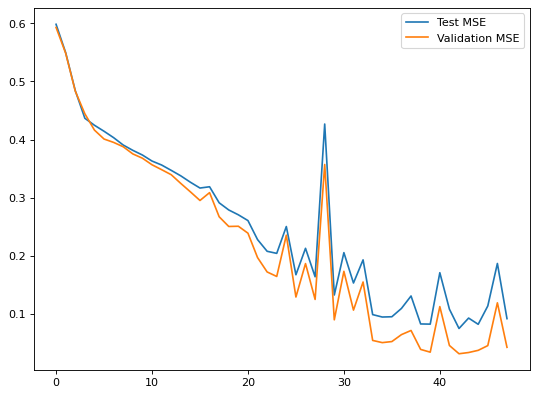

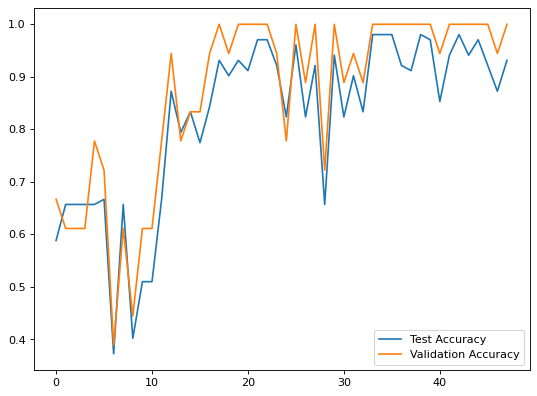

In [360]:
# Iris Classification
# Load iris data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff &> /dev/null

irisData = arff.loadarff('iris.arff')

# Shuffle data
irisDf = pd.DataFrame(irisData[0])
irisDf = shuffle(irisDf)

# Construct one hot encoding
irisYDf = irisDf["class"]
irisYNp = np.array(irisYDf)
irisYNp = irisYNp.reshape(len(irisYNp), 1)
encoder = OneHotEncoder(sparse=False)
irisY = encoder.fit_transform(irisYNp)

# split train and test
del irisDf["class"]
irisX = irisDf.to_numpy()
partition = round(0.8 * len(irisX))
irisTrainX, irisTestX = irisX[:partition], irisX[partition:]
irisTrainY, irisTestY = irisY[:partition], irisY[partition:]

# Train on iris data
irisMLP = MLP(momentum=0.5)
irisMLP.fit(irisTrainX, irisTrainY)

# Print weights
# print(*irisMLP.get_weights())
print("Test Accuracy:", round(irisMLP.score(irisTestX, irisTestY), 3))
epochData = irisMLP.getEpochData()
testAcc = [stat[0] for stat in epochData]
testSse = [stat[1] for stat in epochData]
valAcc = [stat[2] for stat in epochData]
valSse = [stat[3] for stat in epochData]

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(testSse, label="Test MSE")
plt.plot(valSse, label="Validation MSE")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(testAcc, label="Test Accuracy")
plt.plot(valAcc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.show()


## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 80/20 splits of the data for the training/test set.
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn. 

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


Test Accuracy with 0.8 learning rate: 0.111
Test Accuracy with 0.5 learning rate: 0.369
Test Accuracy with 0.1 learning rate: 0.106
Test Accuracy with 0.05 learning rate: 0.253
Test Accuracy with 0.01 learning rate: 0.369
Test Accuracy with 0.001 learning rate: 0.136


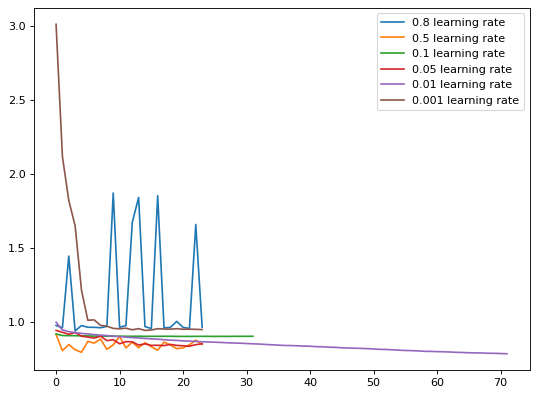

In [351]:
# Train on each dataset
# Load vowel data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff --output vowel.arff &> /dev/null
vowelData = arff.loadarff('vowel.arff')

# Shuffle data
vowelDf = pd.DataFrame(vowelData[0])
vowelDf = vowelDf.apply(LabelEncoder().fit_transform)
vowelDf = shuffle(vowelDf)

# Construct one hot encoding
vowelYDf = vowelDf["Class"]
vowelYNp = np.array(vowelYDf)
vowelYNp = vowelYNp.reshape(len(vowelYNp), 1)
encoder = OneHotEncoder(sparse=False)
vowelY = encoder.fit_transform(vowelYNp)

# Split train and test
del vowelDf["Class"]
vowelX = vowelDf.to_numpy()
partition = round(0.8 * len(vowelX))
vowelTrainX, vowelTestX = vowelX[:partition], vowelX[partition:]
vowelTrainY, vowelTestY = vowelY[:partition], vowelY[partition:]

# Train on vowel data
plt.figure(figsize=(8, 6), dpi=80)
for rate in [0.8, 0.5, 0.1, 0.05, 0.01, 0.001]:
    vowelMLP = MLP(lr=rate, momentum=0.5)
    vowelMLP.fit(vowelTrainX, vowelTrainY)
    epochData = vowelMLP.getEpochData()
    valSse = [stat[3] for stat in epochData]
    plt.plot(valSse, label=str(rate) + " learning rate")
    print("Test Accuracy with", rate, "learning rate:", round(vowelMLP.score(vowelTestX, vowelTestY), 3))

plt.legend(loc="upper right")
plt.show()

## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates. 
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies. 
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, ect) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.



Varying the learning rates effects the amount of change that the weights experience in the face of an error. A high learning rate can overcorrect the weights or even make then worse because we arn't using the true gradient. If a learning rate is too small, it can take forever for the weights to change a significant amount and improve.
The vowel data set might be more difficult because there is more features and 11 classes compaired with 3 on the iris data set. The baseline accuracy of the iris data is 0.332 and the best accuracy I got on it was 1.000. The baseline accuracy of the vowel dataset is 0.091 and the best accuracy I got on it was 0.369.




## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


Test Accuracy with 1 hidden nodes: 0.061
Test Accuracy with 2 hidden nodes: 0.076
Test Accuracy with 4 hidden nodes: 0.061
Test Accuracy with 8 hidden nodes: 0.197
Test Accuracy with 16 hidden nodes: 0.318
Test Accuracy with 32 hidden nodes: 0.364
Test Accuracy with 64 hidden nodes: 0.167


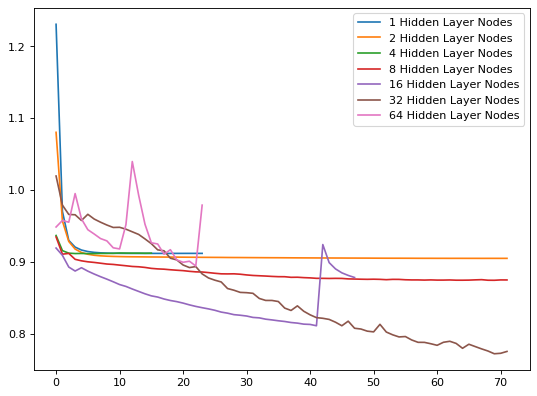

In [353]:
plt.figure(figsize=(8, 6), dpi=80)
for width in [1, 2, 4, 8, 16, 32, 64]:
    vowelMLP = MLP(lr=0.01, momentum=0.5, hiddenLayerWidths=[width])
    vowelMLP.fit(vowelTrainX, vowelTrainY)
    epochData = vowelMLP.getEpochData()
    valSse = [stat[3] for stat in epochData]
    plt.plot(valSse, label=str(width) + " Hidden Layer Nodes")
    print("Test Accuracy with", width, "hidden nodes:", round(vowelMLP.score(vowelTestX, vowelTestY), 3))

plt.legend(loc="upper right")
plt.show()


In my test, the more hidden nodes the better the algorithm did on the validation test and test set up to 32 nodes.

## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- For each momentum term, print the test set accuracy. 
- You are trying to see how much momentum speeds up learning and how it affects accuracy.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


Test Accuracy with 1.01 momentum: 0.086
Test Accuracy with 0.7 momentum: 0.303
Test Accuracy with 0.5 momentum: 0.384
Test Accuracy with 0.2 momentum: 0.439
Test Accuracy with 0.01 momentum: 0.394


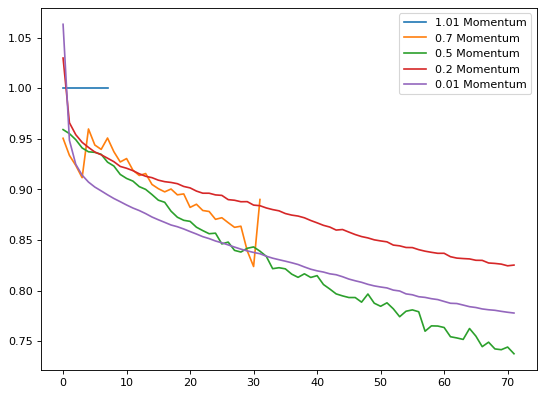

In [355]:
plt.figure(figsize=(8, 6), dpi=80)
for a in [1.01, 0.7, 0.5, 0.2, 0.01]:
    vowelMLP = MLP(lr=0.01, momentum=a, hiddenLayerWidths=[32])
    vowelMLP.fit(vowelTrainX, vowelTrainY)
    epochData = vowelMLP.getEpochData()
    valSse = [stat[3] for stat in epochData]
    plt.plot(valSse, label=str(a) + " Momentum")
    print("Test Accuracy with", a, "momentum:", round(vowelMLP.score(vowelTestX, vowelTestY), 3))

plt.legend(loc="upper right")
plt.show()

Momentum made a big difference with the best being a momentum of 0.5.

## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [375]:
# Iris
irisData = arff.loadarff('iris.arff')

# Shuffle data
irisDf = pd.DataFrame(irisData[0])
irisDf = shuffle(irisDf)

# Construct one hot encoding
irisYDf = irisDf["class"]
irisYNp = np.array(irisYDf)
irisYNp = irisYNp.reshape(len(irisYNp), 1)
encoder = OneHotEncoder(sparse=False)
irisY = encoder.fit_transform(irisYNp)

# split train and test
del irisDf["class"]
irisX = irisDf.to_numpy()
partition = round(0.8 * len(irisX))
irisTrainX, irisTestX = irisX[:partition], irisX[partition:]
irisTrainY, irisTestY = irisY[:partition], irisY[partition:]

print(MLPClassifier(hidden_layer_sizes=(4,), max_iter=10000).fit(irisTrainX.copy(), irisTrainY.copy()).score(irisTestX.copy(), irisTestY.copy()))
print(MLPClassifier(hidden_layer_sizes=(45, 45), max_iter=10000).fit(irisTrainX.copy(), irisTrainY.copy()).score(irisTestX.copy(), irisTestY.copy()))
print(MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=10000).fit(irisTrainX.copy(), irisTrainY.copy()).score(irisTestX.copy(), irisTestY.copy()))
print(MLPClassifier(activation='tanh', max_iter=100000).fit(irisTrainX.copy(), irisTrainY.copy()).score(irisTestX.copy(), irisTestY.copy()))
print(MLPClassifier(learning_rate='adaptive', max_iter=10000).fit(irisTrainX.copy(), irisTrainY.copy()).score(irisTestX.copy(), irisTestY.copy()))
print(MLPClassifier(learning_rate_init=0.1, max_iter=10000).fit(irisTrainX.copy(), irisTrainY.copy()).score(irisTestX.copy(), irisTestY.copy()))
print(MLPClassifier(alpha=0.01, max_iter=10000).fit(irisTrainX.copy(), irisTrainY.copy()).score(irisTestX.copy(), irisTestY.copy()))
print(MLPClassifier(alpha=0.01, max_iter=10000).fit(irisTrainX.copy(), irisTrainY.copy()).score(irisTestX.copy(), irisTestY.copy()))
print(MLPClassifier(nesterovs_momentum=True, solver="sgd", max_iter=10000).fit(irisTrainX.copy(), irisTrainY.copy()).score(irisTestX.copy(), irisTestY.copy()))

0.9333333333333333
0.9333333333333333
0.9666666666666667
0.9333333333333333
0.9333333333333333
0.9333333333333333
0.9333333333333333
0.9333333333333333
0.9666666666666667


At first, it was giving me issues with the fact that it hadn't reached convergence and needed more than the max_iter so I made it huge. Other than that it seems like this is a great MLP that is way faster and consistent than mine. Nesterovs momentum and 3 hidden layers of 10 nodes each had the best result.

## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [330]:
# Load sklearn perceptron

# Train on voting dataset

## 5. (Optional 5% Extra credit) For the vowel data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, and momentum.  

- Compare and discuss the values found with the ones you found in part 3.


*Discuss findings here*